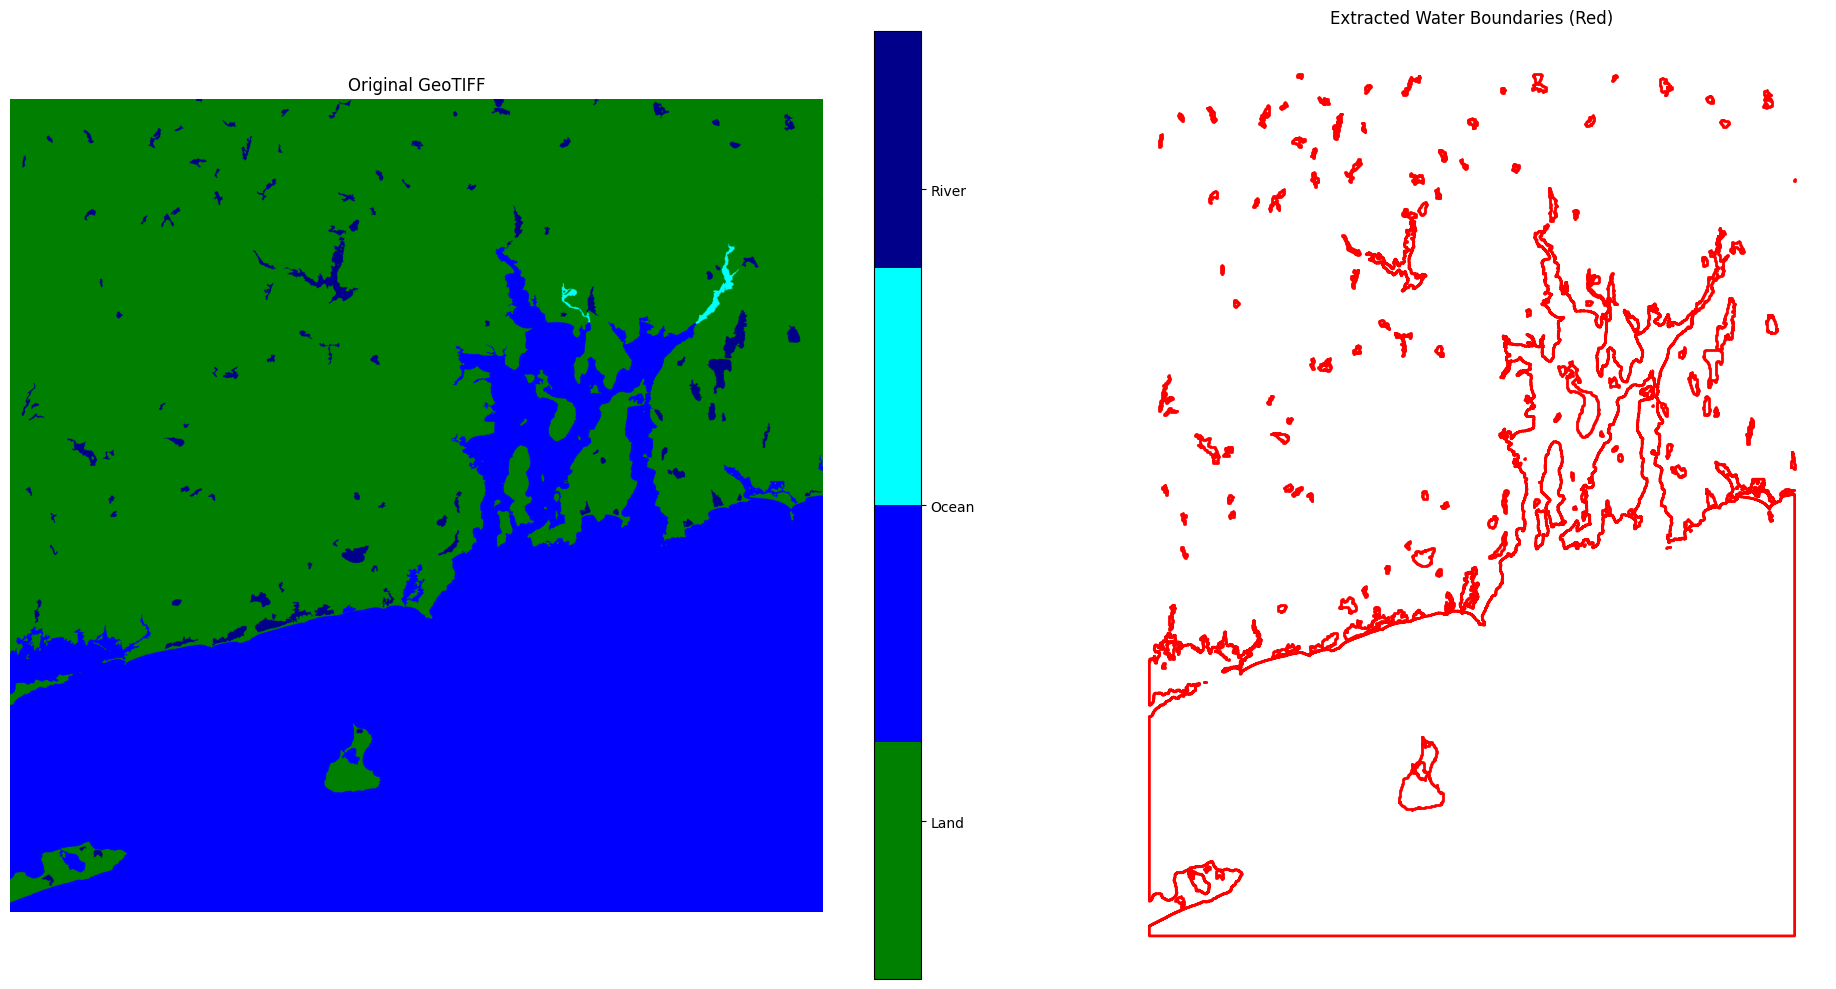

Extracted lower left corner: lat = 41.0, lon = -72.0
UTM Zone: 19
Metric CRS EPSG code: 32619
Surface Areas and Centroid Coordinates for Water Polygons:


,DN,surface_area_m2,centroid_x,centroid_y
0,3.0,1.776106e+05,270807.428733,4.653343e+06
1,3.0,1.789606e+05,311208.868356,4.651923e+06
2,3.0,3.423946e+05,285795.875151,4.652422e+06
3,3.0,8.416412e+05,301330.414976,4.652110e+06
4,3.0,2.315983e+05,284890.341428,4.651890e+06
...,...,...,...,...
119,3.0,3.277722e+05,284574.527952,4.566626e+06
120,3.0,2.284289e+05,255467.872366,4.551498e+06
121,3.0,6.824528e+05,257039.647966,4.550777e+06
122,3.0,7.945822e+05,251867.458124,4.547401e+06


In [39]:
import re
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import folium
from folium.features import GeoJsonTooltip

# Parameters
tiff_file = "ASTWBDV001_N41W072_att.tif"

# Define colormap for DN values
cmap = ListedColormap(['green', 'blue', 'cyan', 'darkblue'])
norm = plt.Normalize(vmin=0, vmax=3)

# Read TIFF and extract polygons
with rasterio.open(tiff_file) as src:
    band1 = src.read(1)
    src_crs = src.crs
    
    mask = band1 > 0
    poly_features = [
        {"geometry": shape(geom), "DN": value}
        for geom, value in shapes(band1, mask=mask, transform=src.transform, connectivity=8)
    ]

# Create GeoDataFrame with appropriate CRS
gdf = gpd.GeoDataFrame(poly_features, crs=src_crs if src_crs else "EPSG:4326")
water_gdf = gdf[gdf["DN"].isin([1, 2, 3])].copy()

# Plot original raster and water boundaries
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(20, 10))

# Original GeoTIFF
im = ax_left.imshow(band1, cmap=cmap, norm=norm)
ax_left.set_title("Original GeoTIFF")
ax_left.axis("off")
cbar = plt.colorbar(im, ax=ax_left, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(["Land", "Ocean", "River", "Lake"])

# Extracted Water Boundaries
ax_right.set_facecolor("white")
water_gdf.boundary.plot(ax=ax_right, color="red", linewidth=2)
ax_right.set_title("Extracted Water Boundaries (Red)")
ax_right.axis("off")

plt.tight_layout()
plt.show()

# Parse filename to determine UTM projection
pattern = r"ASTWBDV\d+_([NS])(\d+)([EW])(\d+)_"
match = re.search(pattern, tiff_file, re.IGNORECASE)
if not match:
    raise ValueError("Filename does not match expected ASTWBD pattern.")

hemi_lat, lat_val, hemi_lon, lon_val = match.groups()
lat_val = -float(lat_val) if hemi_lat.upper() == "S" else float(lat_val)
lon_val = -float(lon_val) if hemi_lon.upper() == "W" else float(lon_val)

print(f"Extracted lower left corner: lat = {lat_val}, lon = {lon_val}")

utm_zone = int((lon_val + 180) // 6) + 1
utm_epsg = 32600 + utm_zone if lat_val >= 0 else 32700 + utm_zone

print("UTM Zone:", utm_zone)
print("Metric CRS EPSG code:", utm_epsg)

# Reproject, calculate area, and compute centroids
water_gdf_metric = water_gdf.to_crs(epsg=utm_epsg)
water_gdf_metric["surface_area_m2"] = water_gdf_metric.geometry.area
water_gdf_metric["centroid"] = water_gdf_metric.geometry.centroid

# Create DataFrame with DN, area, and centroid coordinates
water_gdf_metric["centroid_x"] = water_gdf_metric.centroid.x
water_gdf_metric["centroid_y"] = water_gdf_metric.centroid.y

area_df = water_gdf_metric[["DN", "surface_area_m2", "centroid_x", "centroid_y"]].copy()
print("Surface Areas and Centroid Coordinates for Water Polygons:")
display(area_df)

# Prepare interactive Folium map
water_geo = water_gdf_metric.to_crs(epsg=4326)

centroid_gdf = water_gdf_metric.set_geometry("centroid").to_crs(epsg=4326)
centroid_gdf["centroid_lat"] = centroid_gdf.geometry.y
centroid_gdf["centroid_lon"] = centroid_gdf.geometry.x

map_center = (
    [centroid_gdf["centroid_lat"].mean(), centroid_gdf["centroid_lon"].mean()]
    if not centroid_gdf.empty else [0, 0]
)

m = folium.Map(location=map_center, zoom_start=8)

# Add water boundaries with tooltips
folium.GeoJson(
    water_geo[['geometry', 'DN', 'surface_area_m2']].to_json(),
    name='Water Boundaries',
    style_function=lambda feature: {
        'color': 'red',
        'weight': 2,
        'fillOpacity': 0
    },
    tooltip=GeoJsonTooltip(
        fields=['surface_area_m2', 'DN'],
        aliases=["Surface Area (m²):", "DN:"],
        localize=True
    )
).add_to(m)

# Add centroid markers with tooltips
for _, row in centroid_gdf.iterrows():
    folium.CircleMarker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        radius=5,
        color='black',
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Area: {row['surface_area_m2']:.2f} m²"
    ).add_to(m)

folium.LayerControl().add_to(m)
m